## FFT method for the heat equation:

In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt

# For solving the ODEs
import scipy.integrate as sint

### 1. Define the computational domain:

$u_t = c^2 u_{xx}$

In [2]:
# Define constants
c_2 = 1.0 # difussivity constant

# The domain has to be periodic

# Length of the box/domain
L = 100.

# Discretisation of the domain
N = 1000

# Define the step size
h = L/N

# Creta the x-axis

x = np.arange(-L/2, +L/2, h)

#print(x.shape)

### 2. Set up the ICs:

In [4]:
# Initial conditions

u_0 = np.zeros(len(x), dtype= complex)

#print(u_0.shape)

# Replace zeroes with cos(4*pi*x/L), alpha should be 4*pi/L

u_0[int((L / 2 - L / 8)/h):int((L / 2 + L / 8)/h)]  = np.cos(4*np.pi*x[int((L / 2 - L / 8)/h):int((L / 2 + L / 8)/h)]/L)


#print(u_0)

### 3. Plottingthe ICs:

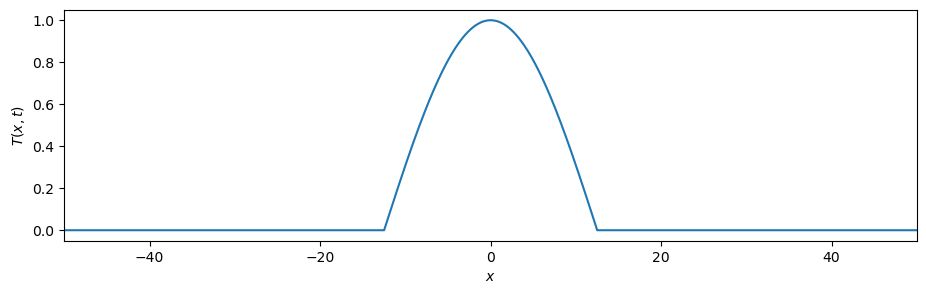

In [6]:
# Let's check with a plot of the ICs

plt.figure(figsize=(11, 3))

plt.plot(x, u_0.real)

plt.xlabel(r"$x$")
plt.ylabel(r"$T(x,t)$")

plt.xlim(-50., +50.)
plt.show()


## Fourier analysis:

### 4. Get the spatial frequencies for Fourier analysis:

In [7]:
# Wavenumbers = spatial frequencies:

k_numbers = 2*np.pi*np.fft.fftfreq(len(x), d = h)

#print(N, len(x))
#print(k_numbers)

### 5. FFT the initial temperature profile:

In [9]:
# Fourier transform
u_0_fourier = np.fft.fft(u_0)

# Safe checks:
#print(u_0_fourier)
print(u_0.shape, u_0_fourier.shape)

(1000,) (1000,)


In [10]:
# Norm of Fourier transform

ampli_u_0_fourier = np.abs(u_0_fourier)/(u_0_fourier.size//2)

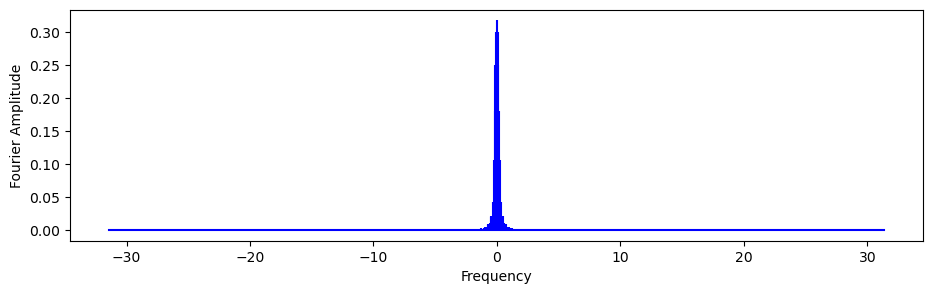

In [11]:
plt.figure(figsize = (11, 3))
plt.stem(k_numbers, ampli_u_0_fourier, 'b', markerfmt=" ", basefmt="-b")
plt.xlabel('Frequency')
plt.ylabel('Fourier Amplitude')

plt.show()

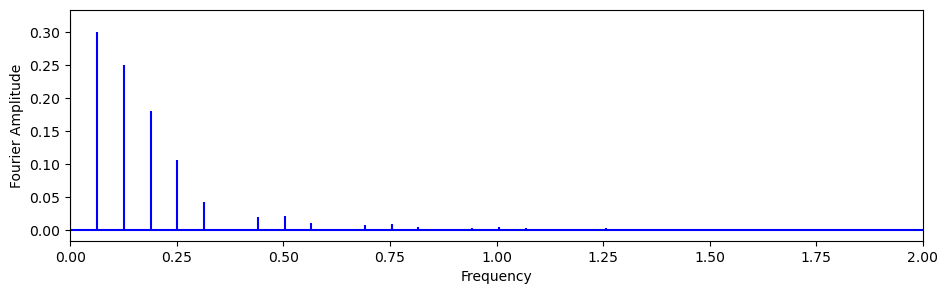

In [12]:
plt.figure(figsize = (11, 3))
plt.stem(k_numbers, ampli_u_0_fourier, 'b', markerfmt=" ", basefmt="-b")
plt.xlabel('Frequency')
plt.ylabel('Fourier Amplitude')
plt.xlim(0,2)
plt.show()

### 6. Concatenate real and complex numbers:


In [14]:
# Preliminary checks:
#print(u_0_fourier)

print(u_0_fourier[3])

print(u_0_fourier[3].real)
print(u_0_fourier[3].imag)


(-90.03311260689838-1.2042040765966478e-11j)
-90.03311260689838
-1.2042040765966478e-11


In [15]:
# IMPORTANT: we concatenate the real and imag #'s

u_0_fourier_conc = np.concatenate((u_0_fourier.real,u_0_fourier.imag))

print(u_0_fourier_conc.shape)

(2000,)


### 7. Time discretisation:

In [29]:
# Simulation time
b = 100.

# Time step
t_step = 1.

# Time axis:
t = np.arange(0., b, t_step)

print(t.shape)

(100,)


In [30]:
print(k_numbers.shape)

(1000,)


## Core of the FFT analysis:

### 8. Construct ODE (RHS of ODE)

In [31]:
# Function to get RHS

def rhs_ode(u_0_fourier_conc, t, k_numbers, c_2):
    """
    Function to calculate the slope of the k-ODEs in Fourier space.
    Inputs: concatenated array with Fourier #'s -> u_0_fourier_conc
            time axis -> t
            spatial freq/wavenumbers -> k_numbers
            dif. coef -> c_2
    """
    # Pasting both arrays back into a single one
    # Needed to input the ODE integrator later.
    u_tilde = u_0_fourier_conc[:N] + (1j)*u_0_fourier_conc[N:]
    
    # We compute the RHS
    rhs_u_tilde = -(c_2**2)*(k_numbers**2)*u_tilde
    
    # Write the output slopes for the integrator:
    rhs_ode = np.concatenate((rhs_u_tilde.real, rhs_u_tilde.imag))
    
    return rhs_ode

In [32]:
print(rhs_ode(u_0_fourier_conc, t, k_numbers, c_2).shape)

(2000,)


### 9. Integrating our k ODEs to find the solution for ${\hat u}= {\hat T}$

In [33]:
# We call odeint (allows to solve systems of ODEs)

solution = sint.odeint(rhs_ode, u_0_fourier_conc, t, args = (k_numbers, c_2))


print(solution.shape)

(100, 2000)


### 10. Reconstruct Complex solution:

This step gives us the solution in Fourier space.

In [34]:
# Combine the first N elements (Real) with the last N elements (Imag)
# In Fourier space
u_solution = solution[:, :N] + (1j)*solution[:, N:]

print(u_solution.shape)

(100, 1000)


### 11. Inverse Fourier transform of each u_solution

In [35]:
# Empty sln in real space:
inv_u_solution = np.zeros(u_solution.shape, dtype = complex)

print(inv_u_solution)

[[0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 ...
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]]


In [36]:
# For loop with 'n' as index

for n in range(len(t)):
    
    inv_u_solution[n, :] = np.fft.ifft(u_solution[n, :])
    

In [37]:
# Check the sln in real space

print(inv_u_solution)

[[-2.84217094e-17+1.54932282e-30j -9.94759830e-17-4.51021390e-19j
   5.68434189e-17-1.27035732e-17j ...  8.52651283e-17-7.21227704e-18j
   5.68434189e-17+1.98692107e-17j  1.13686838e-16+4.63998611e-18j]
 [-1.38442147e-13-9.56244109e-18j  1.38896894e-13-1.04153527e-17j
  -1.38413725e-13-1.13521119e-17j ...  1.38982159e-13+9.45632761e-19j
  -1.38442147e-13-1.76185524e-18j  1.39095846e-13+5.04880502e-18j]
 [ 3.75862896e-13-9.75255283e-18j -3.75422360e-13-9.91817303e-18j
   3.75891318e-13-1.01600586e-17j ... -3.75479203e-13-2.62903568e-17j
   3.75877107e-13+3.67624529e-17j -3.75365516e-13+4.32918503e-17j]
 ...
 [ 3.05764630e-03-2.68306812e-18j  3.05836619e-03-2.66452171e-18j
   3.06052604e-03-2.66452171e-18j ...  3.06412645e-03+4.39139561e-18j
   3.06052604e-03+3.09761823e-18j  3.05836619e-03+4.25669163e-18j]
 [ 3.20358980e-03-2.66551671e-18j  3.20432939e-03-2.66452848e-18j
   3.20654833e-03-2.77554401e-18j ...  3.21024724e-03+2.02533446e-18j
   3.20654833e-03+1.25862646e-17j  3.20432939e-

### 12. Plotting the solution:

#### A. Temperature-position plot:

In [41]:
# Check tye BCs
print(inv_u_solution[79, -1])
print(inv_u_solution[99, -1])

(0.0010915713191444922+2.3115111746477832e-18j)
(0.0033542322401274023+1.239258311146222e-18j)


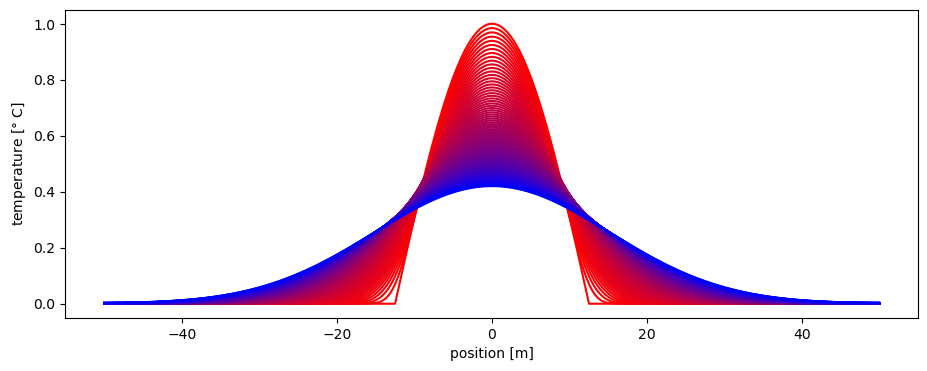

In [40]:
# Add colour

# Number of elements in the time axis:
m = len(t)

# Create our RGB scheme using 'm'
R = np.linspace(1, 0, m)
G = 0
B = np.linspace(0, 1, m)

# Fig. Environment:
plt.figure(figsize= (11, 4))

for j in range(m):
    plt.plot(x, inv_u_solution[j, :], color = [R[j], G, B[j]])

plt.xlabel("position [m]")
plt.ylabel("temperature [$\degree$ C]")

plt.show()

#### B. Surface plot in 3D:

In [42]:
from mpl_toolkits.mplot3d import axes3d

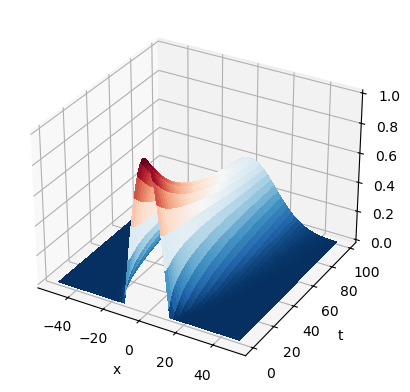

In [43]:
# Grid
x_grid, t_grid = np.meshgrid(x, t)

# Plot
fig = plt.figure()

ax = plt.axes(projection='3d')
#ax.contour3D(x_grid, t_grid, u, 1000, cmap='viridis')
# Creates 'n=10' contours at different Z to make the surface

ax.plot_surface(x_grid, t_grid, inv_u_solution.real, cmap='RdBu_r', linewidth=0, antialiased=False)

ax.set_xlabel('x')  # Customised labels for axes
ax.set_ylabel('t')
ax.set_zlabel('T')

plt.show()

#### C. 2D projection of the surface onto the x vs. t plane

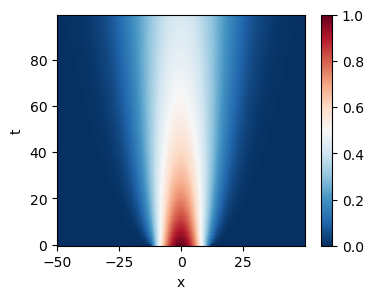

In [45]:
plt.figure(figsize= (4, 3))

#ax = plt.axes(projection='3d')
#ax.contour3D(x_grid, t_grid, u, 1000, cmap='viridis') # Creates 'n=10' contours at different Z to make the surface

z_temp = plt.pcolor(x_grid, t_grid, inv_u_solution.real, cmap='RdBu_r')

plt.colorbar(z_temp)

plt.xlabel('x')
plt.ylabel('t')
#plt.zlabel('T')

plt.show()